In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import heapq
from io import StringIO

# ==========================================
# 1. CHUẨN BỊ DỮ LIỆU (Dùng dữ liệu của bạn)
# ==========================================
file_content = """IdStart	IdEnd	Length
0	19	50.0
0	4	50.7
1	20	23.5
2	1	26.5
3	20	33.8
4	7	49.3
5	6	39.8
6	7	50.0
7	8	48.1
7	23	50.0
8	22	51.9
9	10	25.4
10	24	19.1
11	12	22.9
12	13	29.0
13	14	44.5
14	15	26.5
15	18	100.0
16	9	109.0
17	11	77.2
18	2	200.0
19	21	50.0
19	5	60.2
20	0	50.0
21	16	46.5
22	18	100.0
23	3	66.2
24	22	100.0
24	17	100.0
"""

# Tạo đồ thị
df = pd.read_csv(StringIO(file_content), sep='\t')
G = nx.from_pandas_edgelist(df, source='IdStart', target='IdEnd', edge_attr='Length')
for u, v in G.edges(): G[u][v]['weight'] = G[u][v]['Length'] # Chuẩn hóa trọng số

# Tạo vị trí vẽ (Layout)
pos = nx.spring_layout(G, seed=42) 

# Giả lập các điểm sự kiện (Data Points) rải rác trên bản đồ
# (Tôi chọn tay một số điểm để đảm bảo ví dụ sinh động)
all_data_points = [0, 4, 7, 19, 20, 21, 5, 1, 2, 8, 23]

In [4]:
# ==========================================
# 2. HÀM VẼ TRỰC QUAN HÓA (VISUALIZER)
# ==========================================
def visualize_algo1_LSPD(G, center_node, eps, data_points, pos):
    
    # --- BƯỚC 1: CHẠY THUẬT TOÁN TÌM ĐƯỜNG (DIJKSTRA) ---
    distances = {center_node: 0}
    queue = [(0, center_node)]
    
    visited_edges = []   # Lưu vết các con đường đã đi qua (để tô màu đỏ)
    found_neighbors = [] # Lưu các hàng xóm tìm thấy (để tô màu xanh)
    
    print(f"--- BẮT ĐẦU TÌM KIẾM TỪ NODE {center_node} (EPS={eps}) ---")
    
    while queue:
        curr_dist, u = heapq.heappop(queue)
        
        if curr_dist > eps: continue # Dừng nếu quá xa
        
        # Nếu điểm này nằm trong danh sách dữ liệu -> Là hàng xóm
        if u in data_points and u != center_node:
            found_neighbors.append(u)
            
        # Mở rộng sang các điểm kề
        for v in G.neighbors(u):
            weight = G[u][v]['weight']
            new_dist = curr_dist + weight
            
            # Chỉ đi tiếp nếu con đường này vẫn nằm trong bán kính Eps
            if new_dist <= eps:
                # Lưu cạnh để vẽ (sắp xếp tuple để không bị trùng chiều đi/về)
                edge = tuple(sorted((u, v)))
                if edge not in visited_edges:
                    visited_edges.append(edge)
                    print(f"  > Đi qua: {u} -> {v} (Dài {weight:.1f}). Tổng: {new_dist:.1f}")
                
                if new_dist < distances.get(v, float('inf')):
                    distances[v] = new_dist
                    heapq.heappush(queue, (new_dist, v))

    # --- BƯỚC 2: VẼ HÌNH ---
    plt.figure(figsize=(12, 8))
    
    # 1. Vẽ nền (Mờ nhạt)
    nx.draw_networkx_edges(G, pos, edge_color='#DDDDDD', width=1) # Mạng lưới xám
    nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color='#EEEEEE', node_size=50) # Nút xám
    
    # 2. Vẽ các điểm dữ liệu "người lạ" (Màu đen)
    # (Những điểm này là sự kiện, nhưng nằm ngoài tầm với)
    outsiders = [n for n in data_points if n not in found_neighbors and n != center_node]
    nx.draw_networkx_nodes(G, pos, nodelist=outsiders, node_color='gray', node_size=150, label='Sự kiện (Quá xa)')
    
    # 3. Vẽ đường đi trong phạm vi Eps (Màu đỏ)
    nx.draw_networkx_edges(G, pos, edgelist=visited_edges, edge_color='red', width=4, alpha=0.7, label='Phạm vi LSPD (Eps)')
    
    # 4. Vẽ Hàng xóm tìm được (Màu xanh lá)
    if found_neighbors:
        nx.draw_networkx_nodes(G, pos, nodelist=found_neighbors, node_color='#00FF00', edgecolors='black', node_size=300, label='Hàng xóm (Neighbors)')
    
    # 5. Vẽ Tâm (Ngôi sao vàng)
    nx.draw_networkx_nodes(G, pos, nodelist=[center_node], node_color='yellow', edgecolors='black', node_size=500, node_shape='*', label='Tâm (Center)')

    # 6. Nhãn và Chú thích
    nx.draw_networkx_labels(G, pos, font_size=9, font_family='sans-serif')
    
    # Hiện độ dài lên các cạnh màu đỏ để chứng minh
    edge_labels = {e: f"{G.edges[e]['weight']:.0f}" for e in visited_edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_weight='bold')

    plt.title(f"Mô phỏng Thuật toán 1: Tìm kiếm Lân cận (LSPD)\nTừ điểm {center_node} với bán kính Eps={eps}", fontsize=14)
    plt.legend(loc='upper right', frameon=True, shadow=True)
    plt.axis('off')
    plt.show()

--- BẮT ĐẦU TÌM KIẾM TỪ NODE 0 (EPS=55.0) ---
  > Đi qua: 0 -> 19 (Dài 50.0). Tổng: 50.0
  > Đi qua: 0 -> 4 (Dài 50.7). Tổng: 50.7
  > Đi qua: 0 -> 20 (Dài 50.0). Tổng: 50.0


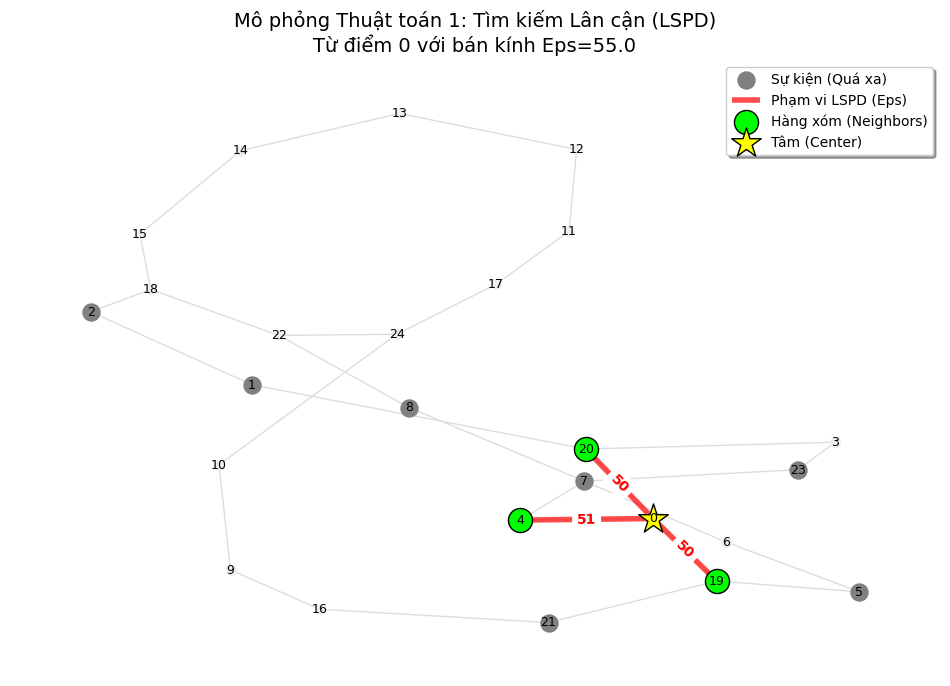

In [5]:
# ==========================================
# 3. CHẠY DEMO
# ==========================================

# Kịch bản:
# Ta đứng ở Node 0 (Tâm).
# Eps = 55.0
# Theo dữ liệu:
# 0 -> 19 (50.0m) : <= 55 -> LÀ HÀNG XÓM
# 0 -> 4 (50.7m)  : <= 55 -> LÀ HÀNG XÓM
# 0 -> 20 (50.0m) : <= 55 -> LÀ HÀNG XÓM (Vì 20 nối với 0 dài 50)
# Nhưng từ 19 đi tiếp đến 5 tốn thêm 60m nữa -> Tổng > 55 -> KHÔNG PHẢI HÀNG XÓM

visualize_algo1_LSPD(G, center_node=0, eps=55.0, data_points=all_data_points, pos=pos)